In [1]:
import networkx as nx
import os
from random import sample,choice,shuffle
from datetime import datetime
from datetime import timedelta
import numpy as np
import threading
import time
from numba import jit, cuda 

<h1>Extraccion de datos</h1>
<p>En esta parte obtendremos los datos que necesitamos para poder trabajarlos de una manera más comoda, para ello se utilizo una lista de 2 dimensiones, en donde se iran almacenando los datos de la siguiente manera:</p>
<p>{Comuna, poblacion, fecha1,...,fechaN}<br>
En fechas se iran almacenando arreglos de tamaño 2 donde la posición 0 indica los contagios a esa fecha, y la posición 1 la cantidad de muertos hasta la fecha.</p>

In [3]:
contagiados=open("../Datos-COVID19/output/producto1/Covid-19.csv",'r')
muertes=open("../Datos-COVID19/output/producto38/CasosFallecidosPorComuna.csv",'r')
datos_contagiados=(contagiados.readlines())
datos_muertes=(muertes.readlines())
#en 5 empiezan las fechas
#en 4 esta la poblacion
datos=list()
#cabecera
separacion=datos_contagiados[0].split(',')
aux=[separacion[2],str(separacion[4])]
cont=0
for i in separacion:
    if(i=='Tasa\n'):
        break
    if(cont<5):
        cont=cont+1
        continue
    else:
        aux.append(i)
datos.append(aux)
#contenido de la lista 
flag=True
contador=0

for j in datos_contagiados:
    if(flag):
        flag=False
        contador=contador+1
        continue
    if(j.split(',')[4]==""):
        contador=contador+1
        continue
    else:
        separacion=j.split(',')
        aux=[separacion[2],str(separacion[4])]
        cont=0
        suma_contagiados=0
        suma_muertes=0
        for i in separacion:
            if(i=='Tasa\n'):
                break
            if(cont<5):
                cont=cont+1
                continue
            else:
                try:
                    fecha=datos[0][cont-3]
                except Exception as e:
                    break
                if(fecha=='Tasa\n'):
                    break
                try:
                    indice=datos_muertes[0].split(',').index(fecha)
                    n_muertes=float(datos_muertes[contador].split(',')[indice])
                except Exception as e:
                    n_muertes=0
                if(i==""):
                    i=0
                valcontagio=float(i)-suma_contagiados
                if(valcontagio<=0):
                    valcontagio=0
                val_muertes=n_muertes-suma_muertes
                if(val_muertes<=0):
                    val_muertes=0
                recuperados=valcontagio-val_muertes
                cont=cont+1
                aux.append([int(valcontagio),int(val_muertes)])
                suma_contagiados=float(i)
                suma_muertes=n_muertes
    contador=contador+1
    aux.pop(len(aux)-1)
    datos.append(aux)
    

print(datos)

[['Comuna', 'Poblacion', '2020-03-30', '2020-04-01', '2020-04-03', '2020-04-06', '2020-04-08', '2020-04-10', '2020-04-13', '2020-04-15', '2020-04-17', '2020-04-20', '2020-04-24', '2020-04-27', '2020-05-01', '2020-05-04', '2020-05-08', '2020-05-11', '2020-05-15', '2020-05-18', '2020-05-22', '2020-05-25', '2020-05-29', '2020-06-01', '2020-06-05', '2020-06-08', '2020-06-12', '2020-06-15', '2020-06-19', '2020-06-23', '2020-06-28', '2020-07-01', '2020-07-05', '2020-07-10', '2020-07-13', '2020-07-17', '2020-07-20', '2020-07-24', '2020-07-27', '2020-07-31', '2020-08-03', '2020-08-07', '2020-08-10', '2020-08-14', '2020-08-17', '2020-08-21', '2020-08-24', '2020-08-28', '2020-08-31', '2020-09-04', '2020-09-07', '2020-09-11', '2020-09-14', '2020-09-18', '2020-09-21', '2020-09-25', '2020-09-28', '2020-10-02', '2020-10-05', '2020-10-09', '2020-10-12', '2020-10-16', '2020-10-19', '2020-10-24', '2020-10-26', '2020-10-30', '2020-11-02', '2020-11-06', '2020-11-09', '2020-11-13', '2020-11-16'], ['Arica'

<center><h1>Función para obtener vecinos no contagiados.</h1></center>
<p>En esta función se recorre el grafo tomando a los nodos contagiados para así considerar a los vecinos, para optimizar este código y que no se recorra el grafo completo es que se le pasa una lista con los nodos que ya estan infectados.</p>
<br>
<p> Esta funcion es utilizada para la predicción ya que de esta forma tendremos en cuenta los nodos con mayor probabilidad de contagio
</p>

In [4]:
def get_vecinos_no_infectados(G,nodos_contagiados):
    lista=list()
    for i in nodos_contagiados:
        if(G.nodes[i]['infected']>0 and G.nodes[i]['infected']<11):
            vecinos= G.neighbors(1)
            for j in vecinos:
                if(G.nodes[j]['infected']>0 and G.nodes[j]['infected']<11):
                    continue
                else:
                    lista.append(j)
    return lista

<center><h1>Función para contagiar nodos de manera aleatoria.</h1></center>

<p>Esta función es utilizada para contagiar nodos de manera aleatoria, para ello toma como parametro los contagiados y muertos que existen hasta la fecha de esta manera contagia nodos de manera aleatoria y además se consideran los muertos y se van eliminando del grafo de esta forma se tiene algo cercano a la realidad en cuanto a cantidad de nodos existentes, tambien se consideran los dias de contagio por ello se le suman los dias a los nodos que ya estan contagiados desde una fecha previa.</p>

In [5]:
def listarandom(contagios,muertos,G,fecha):
    nodos_contagiados=list()
    #sacar contagios viejos y setear variable con contagiados
    for i in G.nodes:
        if (G.nodes[i]['infected']>0 and G.nodes[i]['infected']<11):
            fecha_infeccion=datetime(int(G.nodes[i]['fecha_infeccion'].split("-")[0]),int(G.nodes[i]['fecha_infeccion'].split("-")[1]),int(G.nodes[i]['fecha_infeccion'].split("-")[2]))
            G.nodes[i]['infected']=int(str(datetime(int(fecha.split("-")[0]),int(fecha.split("-")[1]),int(fecha.split("-")[2]))-fecha_infeccion).split(" ")[0])
            if(G.nodes[i]['infected']>=11):
                G.nodes[i]['infected']=0
                G.nodes[i]['fecha_infeccion']=""
                ##print("se reseteo un nodo")
            else:
                nodos_contagiados.append(i)
    #quitar muertos
    for i in range(0,muertos):
        if(not nodos_contagiados):
            break
        eliminado=choice(nodos_contagiados)
        G.remove_node(eliminado)
        nodos_contagiados.pop(nodos_contagiados.index(eliminado))
    #generar nuevos contagios
    for i in range(0,contagios):
        flag=True
        cont=0
        while(flag):
            cont=cont+1
            if(cont%1000==0):
                print(cont)
            lista_vecinos=get_vecinos_no_infectados(G,nodos_contagiados)
            if (not lista_vecinos):
                nodo_a_infectar=choice(list(G.nodes))
                lista_vecinos=list()
            else:
                nodo_a_infectar=choice(lista_vecinos)
            if(nodo_a_infectar in nodos_contagiados):
                flag=False
            else:
                G.nodes[nodo_a_infectar]['infected']=1
                G.nodes[nodo_a_infectar]['fecha_infeccion']=fecha
                nodos_contagiados.append(nodo_a_infectar)
                lista_vecinos=get_vecinos_no_infectados(G,nodos_contagiados)
                flag=False
    return G

<center><h1>Predicción.</h1></center>

<p>Para la predicción se utilizo una función que genera una lista considerando la probabilidad de contagio obtenida mediante una variable de entrenamiento que varia en las fechas, además se considera la fase en la que esta la comuna para ello se divide entre 10 de esta forma por ejemplo la una comuna en fase 1 (Cuarentena) poseera una menor probabilidad de contagio debido a que existe menor movilidad por tanto es menos probable el contagio entre nodos.
<br>
Luego tomando como referencia esta probabilidad, se realiza una lista random como lo muestra la formula acontinucación
    <img src="pred_form.png" >
<br>
Esta formula genera una lista random con ceros y unos esto quiere decir que si la probabilidad es de 0.5 esto generara una lista con 50 1's y 50 0's de manera aleatoria, luego en base a esta lista se iran tomando numeros randomicos referenciados a los 0's y 1's dentro de la lista y se iran contagiando nodos de manera aleatoria.
</p>
   

In [6]:
def Predecir(G,fase, prob_contagio):# G: Grafo, fase: fase de la comuna, prob_contagio: probabilidad de contagio
    nodos_contagiados=list()
    #prob_contagio=fase/10
    for i in G.nodes:
        if (G.nodes[i]['infected']>0 and G.nodes[i]['infected']<11):#se almacenan los nodos contagiados en una lista
            nodos_contagiados.append(i)
    for i in nodos_contagiados:
        #print(str(i)+" tiene "+str(len(list(G.neighbors(i))))+" vecinos")
        for j in G.neighbors(i):# se consideran los vecinos de los nodos contagiados
            if(G.nodes[j]["infected"]<=0 or G.nodes[j]["infected"]>8):
                lista = [1]*int(prob_contagio*100)+[0]*int((1-prob_contagio)*100)# se genera una lista con la cantidad de 1 y ceros que diga la probabilidad de cotagio
                shuffle(lista)
                var=choice(lista)
                if(var==1):
                    G.nodes[j]["infected"]=1
                #    print("contagio un nodo")
                #else:
                #    print("no contagio un nodo")
    '''for i in G.edges:
        if(i[0] in nodos_contagiados):
            if(G.nodes[i[1]]["infected"]<=0 or G.nodes[i[1]]["infected"]>8):
                lista = [1]*int(prob_contagio*100)+[0]*int((1-prob_contagio)*100)
                shuffle(lista)
                if(choice(lista)==1):
                    G.nodes[i[1]]["infected"]=1'''
    return G
    

In [7]:
import collections
import matplotlib.pyplot as plt
import networkx as nx

def degree_histogram(G):
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())

    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color="b")

    plt.title("Degree Histogram")
    plt.ylabel("Count")
    plt.xlabel("Degree")
    ax.set_xticks([d + 0.4 for d in deg])
    ax.set_xticklabels(deg)
    plt.show()

<center><h1>Creación de red y predicción.</h1></center>
<p> Se pasa por parametro el numero de la comuna a la cual se quiere estudiar el comportamiento y la prediccion para las fechas proximas,
en base a las fechas y considerando la lista previamente generada, en la que se tienen las fechas con el numero de contagiado y el numero de muertos
en cada fecha, con esto se comienzan a generar los grafos considerando la poblacion de la comuna y se contagian randomicamente los nodos dentro de este grafo
utilizando la función listarandom, además tambien se genera un grafo de prediccion que guardara la prediccion para fecha proxima utilizando la funcion prediccion
de momento en esta función se para por parametro la fase 5, ya que aún no se considera ese dato.</p>


In [13]:
#poblacion
def get_comuna(i,datos):
    Promedio_probabilidad=list()
    
    kave= 5
    entrenamiento=0.1
    aux=0
    n=int(int(datos[i][1].split('.')[0])/1)
    if(n<=5):
        n=6
    #aristas
    m=1
    #semilla+
    seed=10
    #G=nx.barabasi_albert_graph(n, m, seed)
    G = nx.fast_gnp_random_graph(n, kave/(n-1))
    fechas=datos[0].copy()# se toma el header de la lista con los datos que contiene {'Comuna','Poblacion','fecha1',...,'fechaN'}
    fechas.pop(0)# se eliminan comuna y población para quedarse con las fechas
    fechas.pop(0)
    #seteo de estados iniciales
    for j in G.nodes:# se consideran todos los nodos sanos en un principaio
        G.nodes[j]['infected']=0
        G.nodes[j]['fecha_infeccion']=""
    for j in range(0,len(fechas)-1):#se recorren las fechas para asi contagiar a los nodos
        G=listarandom(datos[i][j+2][0],datos[i][j+2][1],G,fechas[j])#aquí se genera el grafo considerando los nodos contagiados y los muertos (por fecha).
        G_prediccion = nx.Graph(G)#se crea otro grafo que se utilizara para calcular la prediccion de la proxima fecha.
        #try:
        #    probabilidad=(100/len(get_vecinos_no_infectados(G))*datos[i][j+2][0])
        #    probabilidad=float(str(probabilidad)[:4])
        #except Exception as e:
        #    probabilidad=0
        #Promedio_probabilidad.append(probabilidad)
        #Promedio_probabilidad.append(0)
        #probabilidad=np.mean(Promedio_probabilidad)
        #probabilidad=float(str(probabilidad)[:4])+entrenamiento
        #probabilidad=float(str(probabilidad)[:4])
        entrenamiento=float(str(entrenamiento)[:5])
        probabilidad=entrenamiento
        if(probabilidad<=0.01):
            probabilidad=0.01
        print("probabilidad:",probabilidad)
        G_prediccion=Predecir(G_prediccion,5, probabilidad)# se pasa el grafo y de momento todas las comunas se consideran como fase 5
        infectados=0
        for k in G.nodes:
            if(G.nodes[k]['infected']>0 and G.nodes[k]['infected']<11):
                infectados=infectados+1
        print("fecha="+str(fechas[j])+";contagiados="+str(datos[i][j+2][0])+";muertos="+str(datos[i][j+2][1])+";Comuna="+str(datos[i][0])+" infectados totales="+str(infectados))        
        print("-----------------------------------prediccion-------------------------------")
        arr_real.append(infectados)
        infectados_prediccion=0
        for k in G_prediccion.nodes:
            if(G_prediccion.nodes[k]['infected']>0 and G_prediccion.nodes[k]['infected']<11):
                infectados_prediccion=infectados_prediccion+1
        print("muertos="+str(0)+";Comuna="+str(datos[i][0])+" infectados totales="+str(infectados_prediccion))
        print("------------------------------------------------------------------------")
        if((aux-infectados)<(infectados*-0.25)):
            entrenamiento=entrenamiento+0.01
        elif((aux-infectados)>(infectados*0.25)):
            entrenamiento=entrenamiento-0.01
        aux=infectados_prediccion
        degree_histogram(G)
    return [G,G_prediccion,]
        #aqui hay una variable llamaga "G" que contiene el grafo de la comuna, la comuna la llamas con "str(datos[i][0])" ahi esta
        #el nombre de la comuna
    

probabilidad: 0.1
fecha=2020-03-30;contagiados=0;muertos=0;Comuna=Calama infectados totales=0
-----------------------------------prediccion-------------------------------
muertos=0;Comuna=Calama infectados totales=0
------------------------------------------------------------------------


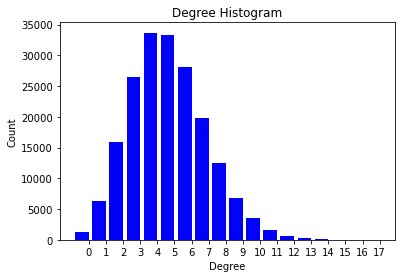

probabilidad: 0.1
fecha=2020-04-01;contagiados=0;muertos=0;Comuna=Calama infectados totales=0
-----------------------------------prediccion-------------------------------
muertos=0;Comuna=Calama infectados totales=0
------------------------------------------------------------------------


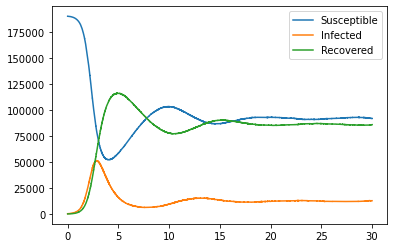

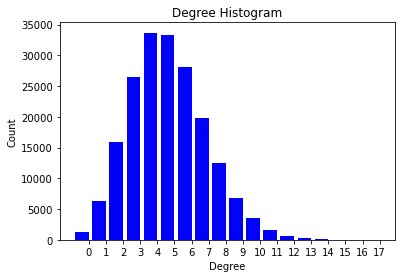

probabilidad: 0.1
fecha=2020-04-03;contagiados=5;muertos=0;Comuna=Calama infectados totales=5
-----------------------------------prediccion-------------------------------
muertos=0;Comuna=Calama infectados totales=6
------------------------------------------------------------------------


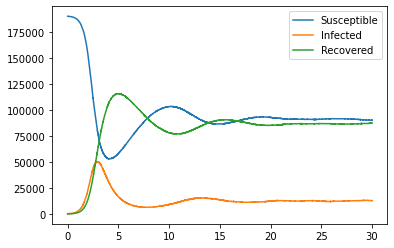

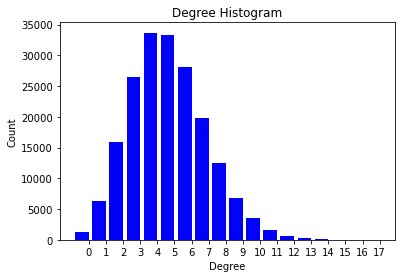

probabilidad: 0.11
fecha=2020-04-06;contagiados=2;muertos=0;Comuna=Calama infectados totales=7
-----------------------------------prediccion-------------------------------
muertos=0;Comuna=Calama infectados totales=13
------------------------------------------------------------------------


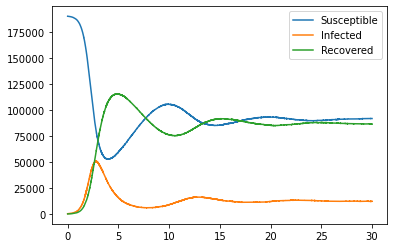

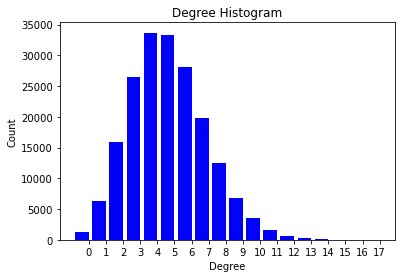

probabilidad: 0.11
fecha=2020-04-08;contagiados=1;muertos=0;Comuna=Calama infectados totales=8
-----------------------------------prediccion-------------------------------
muertos=0;Comuna=Calama infectados totales=14
------------------------------------------------------------------------


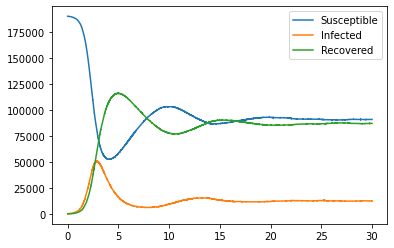

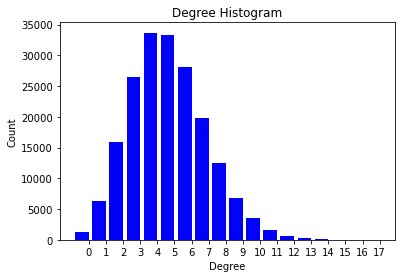

probabilidad: 0.1
fecha=2020-04-10;contagiados=5;muertos=0;Comuna=Calama infectados totales=13
-----------------------------------prediccion-------------------------------
muertos=0;Comuna=Calama infectados totales=19
------------------------------------------------------------------------


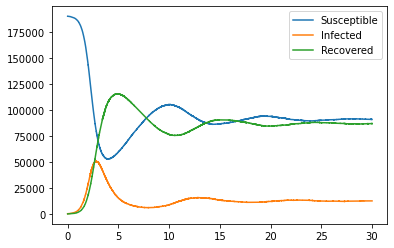

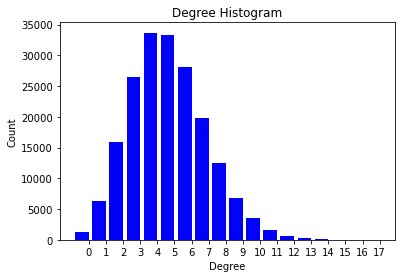

probabilidad: 0.1
fecha=2020-04-13;contagiados=7;muertos=0;Comuna=Calama infectados totales=20
-----------------------------------prediccion-------------------------------
muertos=0;Comuna=Calama infectados totales=25
------------------------------------------------------------------------


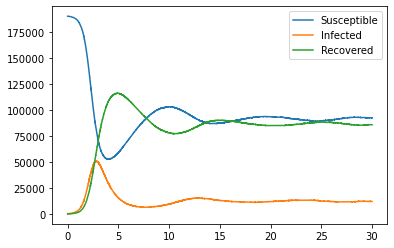

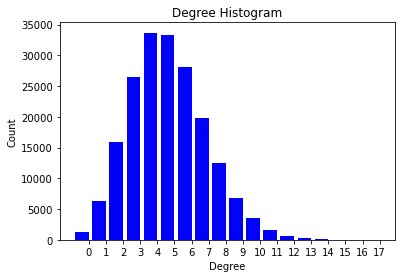

probabilidad: 0.1
fecha=2020-04-15;contagiados=1;muertos=0;Comuna=Calama infectados totales=16
-----------------------------------prediccion-------------------------------
muertos=0;Comuna=Calama infectados totales=21
------------------------------------------------------------------------


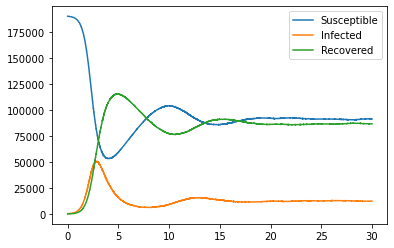

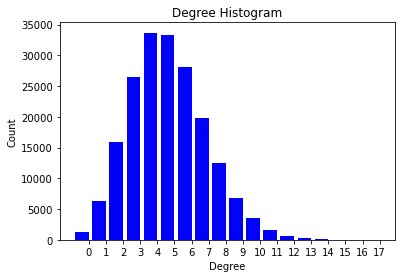

probabilidad: 0.09
fecha=2020-04-17;contagiados=0;muertos=0;Comuna=Calama infectados totales=14
-----------------------------------prediccion-------------------------------
muertos=0;Comuna=Calama infectados totales=18
------------------------------------------------------------------------


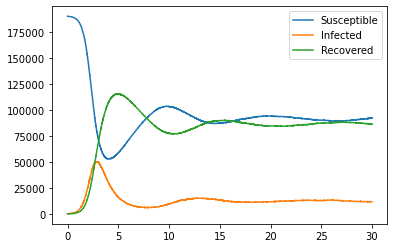

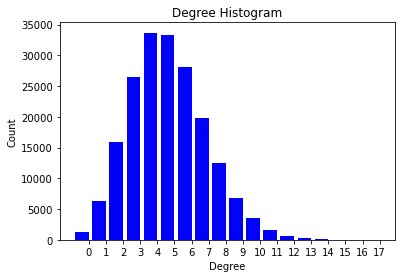

probabilidad: 0.08
fecha=2020-04-20;contagiados=4;muertos=0;Comuna=Calama infectados totales=17
-----------------------------------prediccion-------------------------------
muertos=0;Comuna=Calama infectados totales=21
------------------------------------------------------------------------


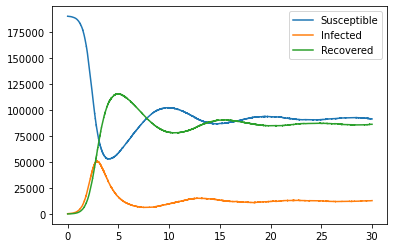

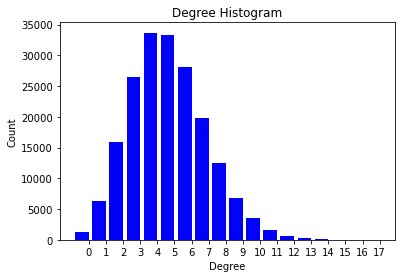

probabilidad: 0.08
fecha=2020-04-24;contagiados=10;muertos=0;Comuna=Calama infectados totales=15
-----------------------------------prediccion-------------------------------
muertos=0;Comuna=Calama infectados totales=23
------------------------------------------------------------------------


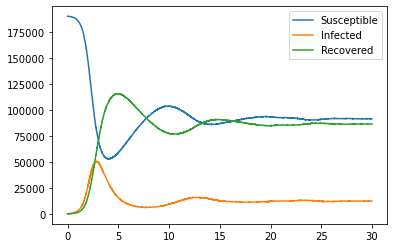

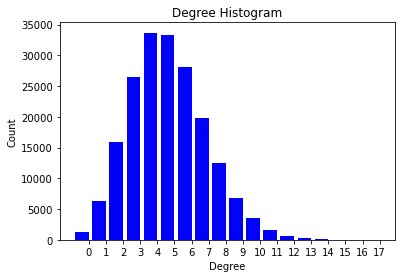

probabilidad: 0.07
fecha=2020-04-27;contagiados=19;muertos=0;Comuna=Calama infectados totales=33
-----------------------------------prediccion-------------------------------
muertos=0;Comuna=Calama infectados totales=42
------------------------------------------------------------------------


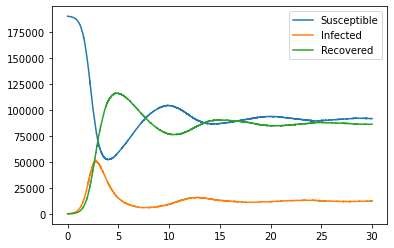

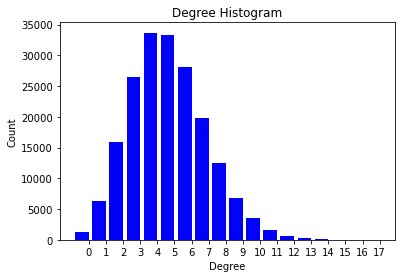

probabilidad: 0.08
fecha=2020-05-01;contagiados=17;muertos=0;Comuna=Calama infectados totales=46
-----------------------------------prediccion-------------------------------
muertos=0;Comuna=Calama infectados totales=66
------------------------------------------------------------------------


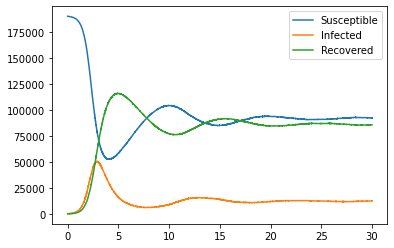

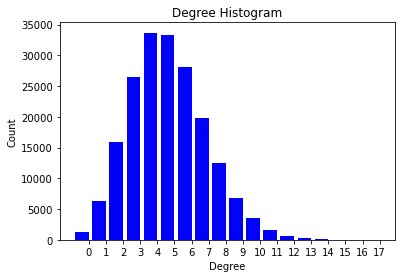

probabilidad: 0.08
fecha=2020-05-04;contagiados=13;muertos=0;Comuna=Calama infectados totales=59
-----------------------------------prediccion-------------------------------
muertos=0;Comuna=Calama infectados totales=80
------------------------------------------------------------------------


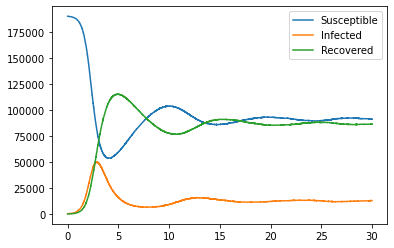

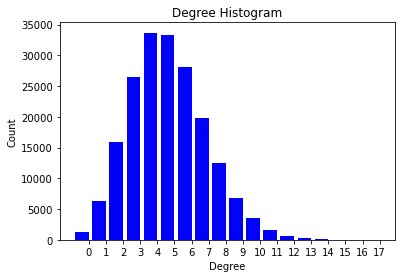

probabilidad: 0.08
fecha=2020-05-08;contagiados=18;muertos=0;Comuna=Calama infectados totales=48
-----------------------------------prediccion-------------------------------
muertos=0;Comuna=Calama infectados totales=60
------------------------------------------------------------------------


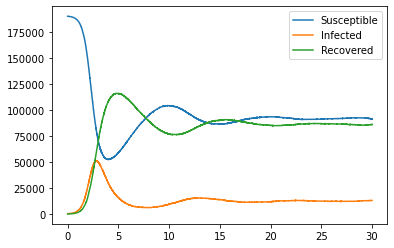

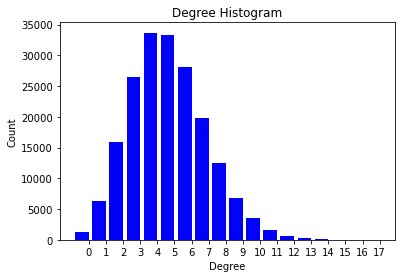

probabilidad: 0.07
fecha=2020-05-11;contagiados=12;muertos=0;Comuna=Calama infectados totales=60
-----------------------------------prediccion-------------------------------
muertos=0;Comuna=Calama infectados totales=81
------------------------------------------------------------------------


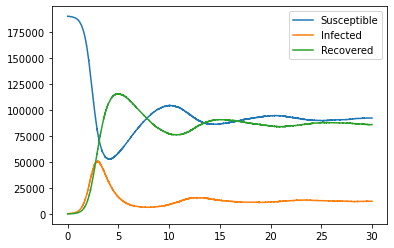

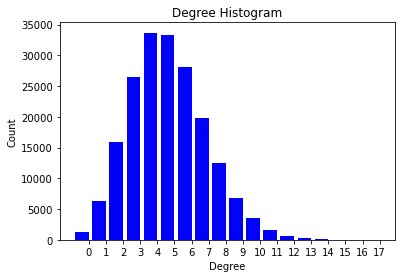

probabilidad: 0.07
fecha=2020-05-15;contagiados=54;muertos=0;Comuna=Calama infectados totales=84
-----------------------------------prediccion-------------------------------
muertos=0;Comuna=Calama infectados totales=114
------------------------------------------------------------------------


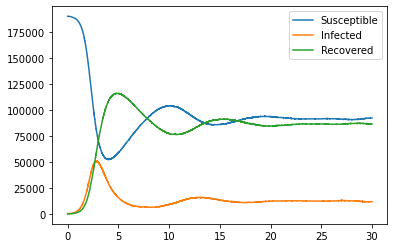

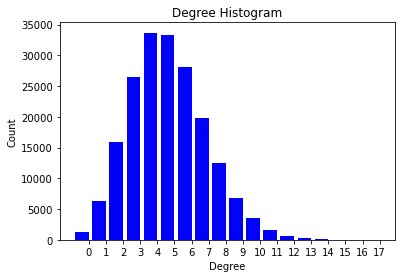

probabilidad: 0.07
fecha=2020-05-18;contagiados=45;muertos=0;Comuna=Calama infectados totales=129
-----------------------------------prediccion-------------------------------
muertos=0;Comuna=Calama infectados totales=183
------------------------------------------------------------------------


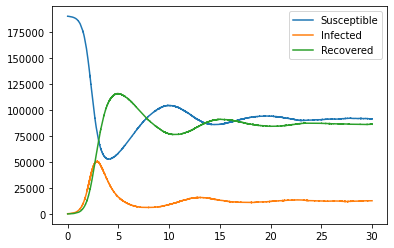

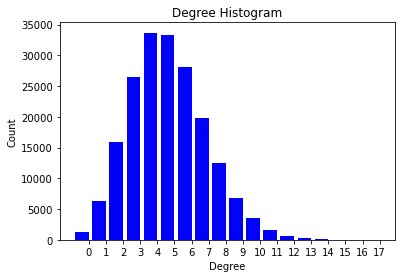

probabilidad: 0.07
fecha=2020-05-22;contagiados=41;muertos=0;Comuna=Calama infectados totales=140
-----------------------------------prediccion-------------------------------
muertos=0;Comuna=Calama infectados totales=179
------------------------------------------------------------------------


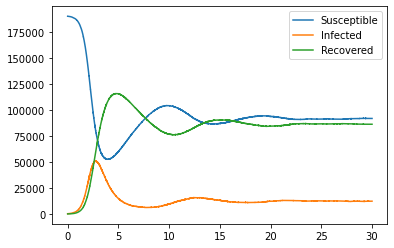

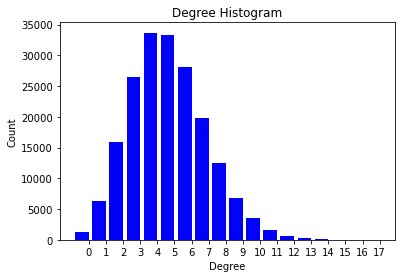

probabilidad: 0.06
fecha=2020-05-25;contagiados=48;muertos=0;Comuna=Calama infectados totales=188
-----------------------------------prediccion-------------------------------
muertos=0;Comuna=Calama infectados totales=243
------------------------------------------------------------------------


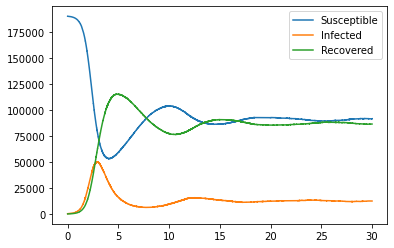

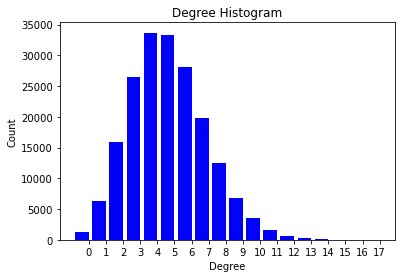

probabilidad: 0.06
fecha=2020-05-29;contagiados=113;muertos=0;Comuna=Calama infectados totales=201
-----------------------------------prediccion-------------------------------
muertos=0;Comuna=Calama infectados totales=279
------------------------------------------------------------------------


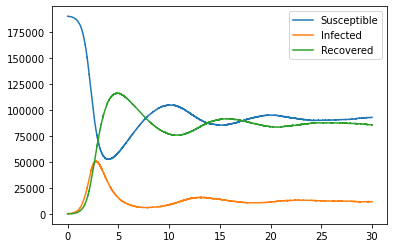

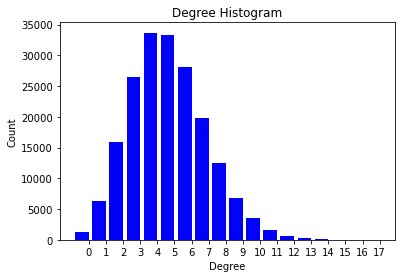

probabilidad: 0.06
fecha=2020-06-01;contagiados=71;muertos=0;Comuna=Calama infectados totales=272
-----------------------------------prediccion-------------------------------
muertos=0;Comuna=Calama infectados totales=360
------------------------------------------------------------------------


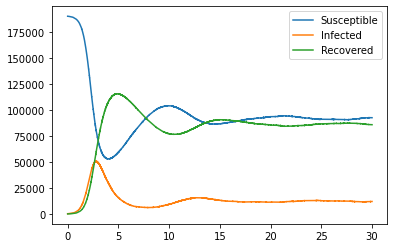

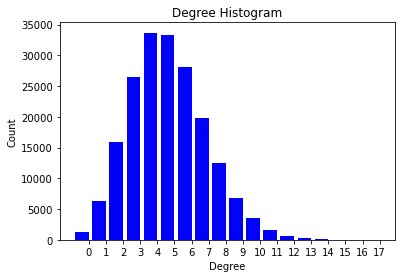

probabilidad: 0.06
fecha=2020-06-05;contagiados=140;muertos=0;Comuna=Calama infectados totales=323
-----------------------------------prediccion-------------------------------
muertos=0;Comuna=Calama infectados totales=440
------------------------------------------------------------------------


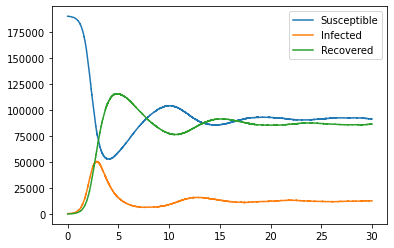

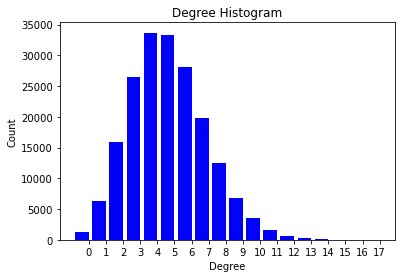

probabilidad: 0.06
fecha=2020-06-08;contagiados=130;muertos=0;Comuna=Calama infectados totales=453
-----------------------------------prediccion-------------------------------
muertos=0;Comuna=Calama infectados totales=608
------------------------------------------------------------------------


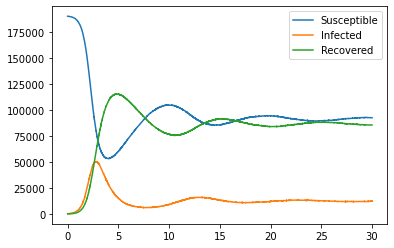

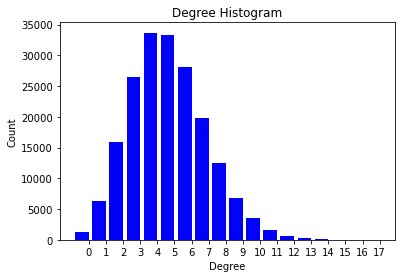

probabilidad: 0.06
fecha=2020-06-12;contagiados=382;muertos=48;Comuna=Calama infectados totales=603
-----------------------------------prediccion-------------------------------
muertos=0;Comuna=Calama infectados totales=777
------------------------------------------------------------------------


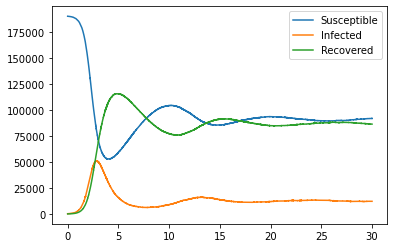

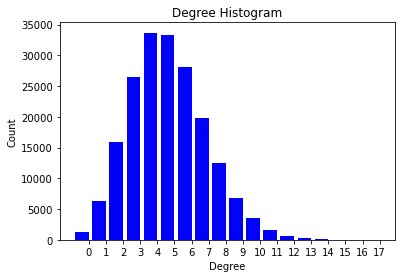

probabilidad: 0.06
fecha=2020-06-15;contagiados=394;muertos=10;Comuna=Calama infectados totales=984
-----------------------------------prediccion-------------------------------
muertos=0;Comuna=Calama infectados totales=1284
------------------------------------------------------------------------


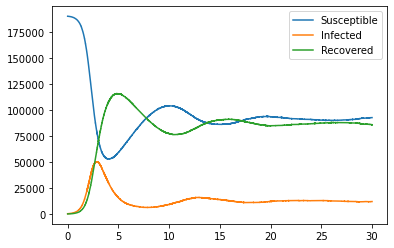

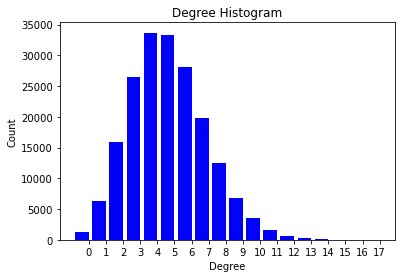

probabilidad: 0.06
fecha=2020-06-19;contagiados=843;muertos=13;Comuna=Calama infectados totales=1595
-----------------------------------prediccion-------------------------------
muertos=0;Comuna=Calama infectados totales=2073
------------------------------------------------------------------------


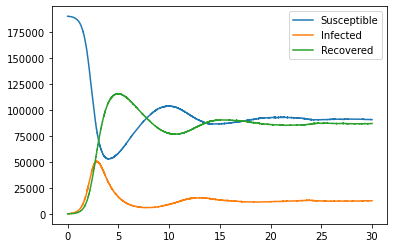

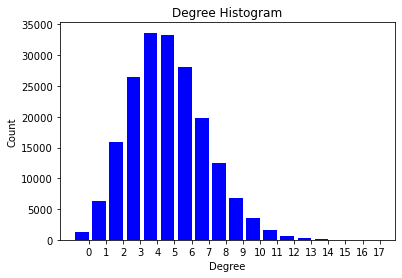

probabilidad: 0.06
fecha=2020-06-23;contagiados=720;muertos=9;Comuna=Calama infectados totales=1932
-----------------------------------prediccion-------------------------------
muertos=0;Comuna=Calama infectados totales=2495
------------------------------------------------------------------------


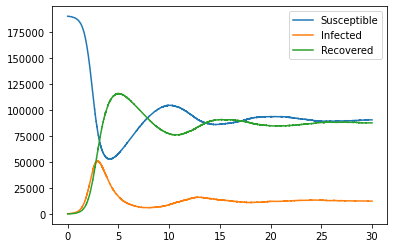

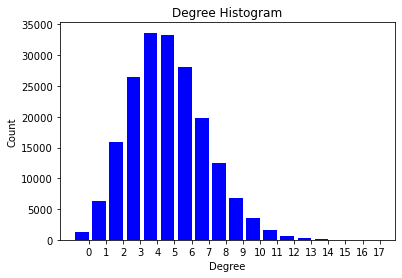

probabilidad: 0.06
fecha=2020-06-28;contagiados=752;muertos=19;Comuna=Calama infectados totales=2277
-----------------------------------prediccion-------------------------------
muertos=0;Comuna=Calama infectados totales=2948
------------------------------------------------------------------------


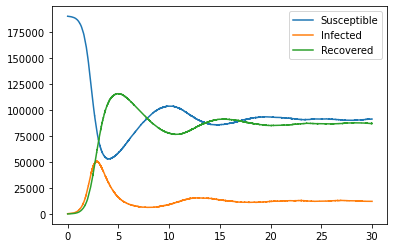

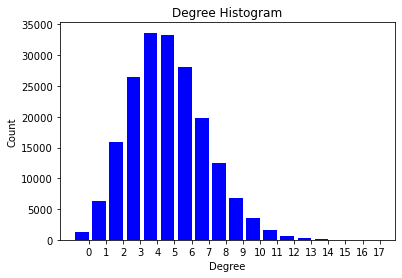

probabilidad: 0.06
fecha=2020-07-01;contagiados=393;muertos=3;Comuna=Calama infectados totales=1832
-----------------------------------prediccion-------------------------------
muertos=0;Comuna=Calama infectados totales=2375
------------------------------------------------------------------------


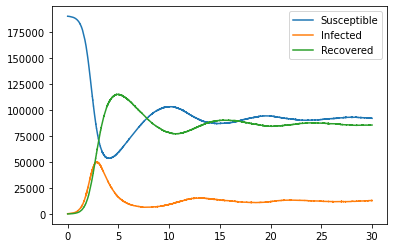

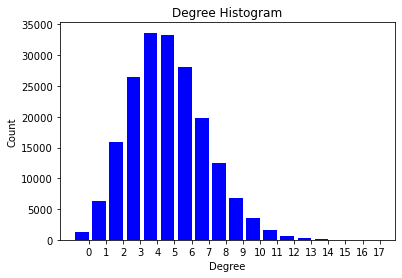

probabilidad: 0.049
fecha=2020-07-05;contagiados=427;muertos=10;Comuna=Calama infectados totales=1542
-----------------------------------prediccion-------------------------------
muertos=0;Comuna=Calama infectados totales=1842
------------------------------------------------------------------------


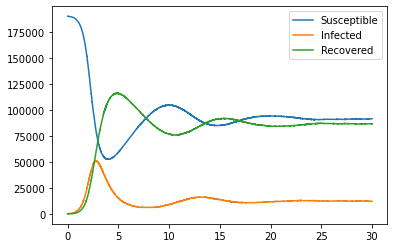

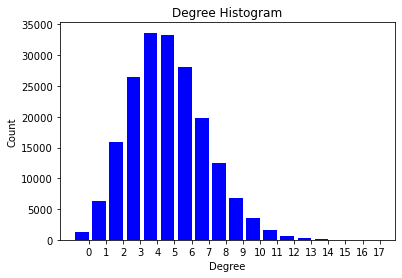

probabilidad: 0.039
fecha=2020-07-10;contagiados=498;muertos=13;Comuna=Calama infectados totales=1287
-----------------------------------prediccion-------------------------------
muertos=0;Comuna=Calama infectados totales=1505
------------------------------------------------------------------------


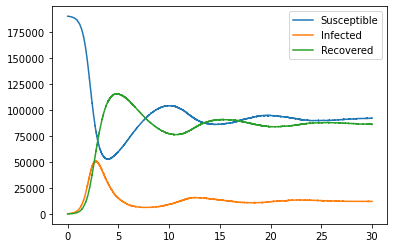

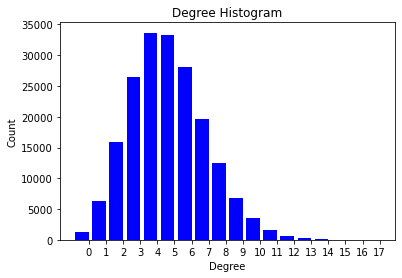

probabilidad: 0.028
fecha=2020-07-13;contagiados=285;muertos=5;Comuna=Calama infectados totales=1187
-----------------------------------prediccion-------------------------------
muertos=0;Comuna=Calama infectados totales=1294
------------------------------------------------------------------------


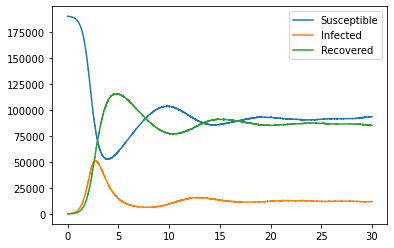

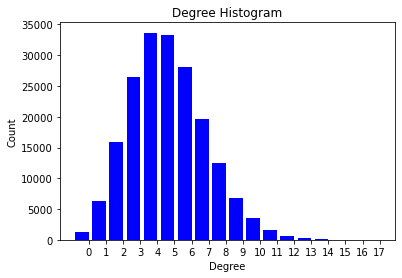

KeyboardInterrupt: 

In [12]:
aux=get_comuna(13,datos)
G=aux[0]
G_prediccion=aux[1]


In [19]:
nx.closeness_centrality(G)

{1: 0.0,
 3: 0.040958524128214165,
 4: 0.07160975803774951,
 5: 0.0033682634730538923,
 6: 0.02097426768085451,
 7: 0.09010034685671885,
 8: 0.12034187975089083,
 9: 0.10304818839578589,
 10: 0.009169161676646706,
 11: 0.03157004630537414,
 13: 0.09030855100890076,
 14: 0.08948145494928861,
 15: 0.013054971138803476,
 16: 0.0023952095808383238,
 17: 0.09051771962733479,
 18: 0.002994011976047904,
 19: 0.000998003992015968,
 20: 0.08917518642122486,
 21: 0.015011643379906854,
 24: 0.0914710952582839,
 25: 0.08927704271639474,
 27: 0.0014970059880239522,
 28: 0.09041301434147321,
 29: 0.013933671119299863,
 30: 0.016582220175034548,
 31: 0.0026732249786142,
 32: 0.006112774451097804,
 33: 0.0890735622771551,
 34: 0.07987945927256372,
 35: 0.016303527398983546,
 36: 0.0029940119760479044,
 37: 0.009791228354102607,
 38: 0.0896868053909393,
 39: 0.046078339644240934,
 40: 0.08917518642122486,
 41: 0.019379363543655048,
 42: 0.015968063872255488,
 43: 0.08777321830230612,
 44: 0.08927704271

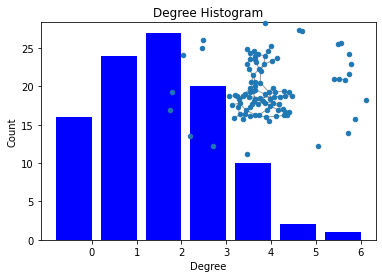

In [49]:
import networkx as nx
G = nx.Graph()
G.add_edge(1,2)
G.add_edge(2,3)
for v in G.nodes():
       G.nodes[v]['state']='X'
G.nodes[1]['state']='Y'
G.nodes[2]['state']='Y'

for i in G.neighbors(1):
    print(i)

2


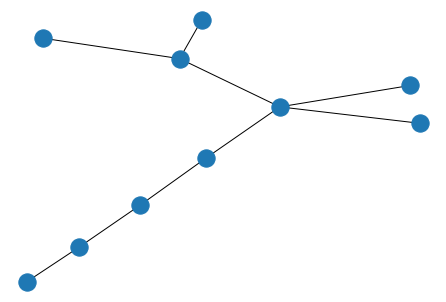

In [30]:
n=10
m=1
seed=10
G=nx.barabasi_albert_graph(n, m, seed)
#print(G.edges)
nx.draw(G)

In [5]:
def worker(count,Hola):
    for i in range(30):
        Hola.append(i)
    return
def llamar():
    Hola=list()
    threads = list()
    for i in range(20):
        t = threading.Thread(target=worker, args=(i,Hola,))
        threads.append(t)
        t.start()
    
    return Hola
print(llamar())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 0, 1, 2, 